<a href="https://colab.research.google.com/github/insightcampus/202008-youth-bigdata/blob/master/%ED%86%A0%ED%94%BD%EB%AA%A8%EB%8D%B8%EB%A7%81_%EC%8B%A4%EC%8A%B51.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# 코랩설치
!sudo apt-get install g++ openjdk-7-jdk # Install Java 1.7+
!sudo apt-get install python-dev; pip install konlpy     # Python 2.x
!sudo apt-get install python3-dev; pip3 install konlpy   # Python 3.x
!sudo apt-get install curl
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package openjdk-7-jdk is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Package 'openjdk-7-jdk' has no installation candidate
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-dev is already the newest version (2.7.15~rc1-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 3.8MB 55.4MB/s 
     |████████████████████████████████| 92kB 8.5MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
docs = ['바나나 사과 포도 포도',
       '사과 포도',
       '포도 바나나',
       '짜장면 짬뽕 탕수육',
       '볶음밥 탕수육',
       '짜장면 짬뽕',
       '된장찌개 김치찌개 김치 비빔밥',
       '김치 된장 비빔밥',
       '비빔밥 김치',
       '사과 볶음밥 김치 된장']

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

n_topic = 3
# 선언
tfidf_vect = TfidfVectorizer()
tfidf = tfidf_vect.fit_transform(docs)
svd =  TruncatedSVD(n_components=n_topic)
u_sigma = svd.fit_transform(tfidf)
svd.components_

array([[ 0.39094311,  0.08663945,  0.2634605 ,  0.08663945,  0.31533599,
         0.1677167 ,  0.33012626,  0.42118555,  0.01907605,  0.01907605,
         0.05422822,  0.58747296],
       [ 0.49683512,  0.13720069,  0.26962551,  0.13720069, -0.29774469,
         0.10773075,  0.49275818, -0.18567019,  0.02131272,  0.02131272,
         0.04450862, -0.51222803],
       [-0.06285924, -0.02901254, -0.00762375, -0.02901254, -0.01957621,
         0.19210545, -0.09004258,  0.00851823,  0.60658392,  0.60658392,
         0.46061907, -0.02794911]])

In [ ]:
vocab = tfidf_vect.get_feature_names()
n =3
for idx, topic in enumerate (svd.components_):
    print("Topic %d:" % (idx), [(vocab[i], topic[i].round(5)) for i in topic.argsort()[:-n - 1]]) 

Topic 0: [('짜장면', 0.01908), ('짬뽕', 0.01908), ('탕수육', 0.05423), ('김치찌개', 0.08664), ('된장찌개', 0.08664), ('볶음밥', 0.16772), ('된장', 0.26346), ('바나나', 0.31534)]
Topic 1: [('포도', -0.51223), ('바나나', -0.29774), ('사과', -0.18567), ('짜장면', 0.02131), ('짬뽕', 0.02131), ('탕수육', 0.04451), ('볶음밥', 0.10773), ('된장찌개', 0.1372)]
Topic 2: [('비빔밥', -0.09004), ('김치', -0.06286), ('김치찌개', -0.02901), ('된장찌개', -0.02901), ('포도', -0.02795), ('바나나', -0.01958), ('된장', -0.00762), ('사과', 0.00852)]


# **단어벡터간의 상관관계**

In [ ]:
# 단어벡터
for i in range(len(vocab)):
    print("{}:{}".format(vocab[i],svd.components_.T[i]))

김치:[ 0.39094311  0.49683512 -0.06285924]
김치찌개:[ 0.08663945  0.13720069 -0.02901254]
된장:[ 0.2634605   0.26962551 -0.00762375]
된장찌개:[ 0.08663945  0.13720069 -0.02901254]
바나나:[ 0.31533599 -0.29774469 -0.01957621]
볶음밥:[0.1677167  0.10773075 0.19210545]
비빔밥:[ 0.33012626  0.49275818 -0.09004258]
사과:[ 0.42118555 -0.18567019  0.00851823]
짜장면:[0.01907605 0.02131272 0.60658392]
짬뽕:[0.01907605 0.02131272 0.60658392]
탕수육:[0.05422822 0.04450862 0.46061907]
포도:[ 0.58747296 -0.51222803 -0.02794911]


In [ ]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
# 코사인유사도
def cosine_similarity(a,b):
    return dot(a,b)/(norm(a)*norm(b))
# 코사인유사도를 사용해서 행렬의 유사도 구하기.
def calc_similarity_matrix(vectors):
    n_word = len(vectors)
    similarity_matrix = np.zeros((n_word,n_word))
    
    for i in range(n_word):
        # 위에서 정의한 코사인 유사도 사용
        for j in range(i, n_word) :
            similarity_matrix[j, i] = cosine_similarity(vectors[i], vectors[j]).round(4)
            
    return similarity_matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_similarity(similarity_matrix) :
  uniform_data = similarity_matrix
  mask = np.triu(np.ones_like(similarity_matrix, dtype=np.bool))
  plt.rcParams['figure.figsize'] = [8,6]
  ax = sns.heatmap(uniform_data, mask=mask,
                   annot=True, fmt=".2f",annot_kws ={'size':8},
                   cmap='coolwarm')

In [ ]:
print(vocab)

['김치', '김치찌개', '된장', '된장찌개', '바나나', '볶음밥', '비빔밥', '사과', '짜장면', '짬뽕', '탕수육', '포도']


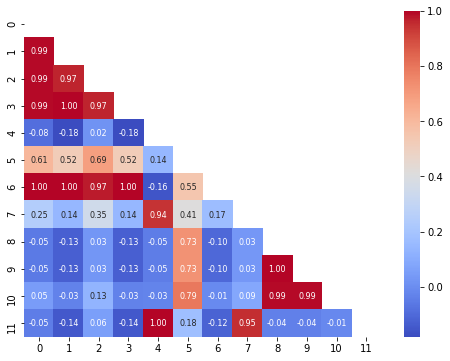

In [ ]:
word_vectors = svd.components_.T
word_similarity_matrix = calc_similarity_matrix(word_vectors)
visualize_similarity(word_similarity_matrix)

# **단어벡터** **시각화**

In [94]:
%matplotlib inline
import matplotlib.font_manager as fm
import matplotlib
# fontprop = fm.FontProperties(fname=path+'data/malgue.ttf', size =12)
fontprop = fm.FontProperties(fname='/content/drive/My Drive/Colab Notebooks/malgun.ttf',size=12)

In [96]:
from sklearn.manifold import TSNE
import numpy as np
vectors = word_vectors
labels = tfidf_vect.get_feature_names()
def visualize_vectors(vectors, labels):
    tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
    np.set_printoptions(suppress=True)
    T = tsne.fit_transform(vectors)
    
    plt.figure(figsize=(10,6))
    plt.scatter(T[:,0], T[:,1], c='orange', edgecolors='r')
    for label, x, y in zip(labels, T[:,0], T[:,1]):
        plt.annotate(label, xy=(x+1, y+1), xytext=(0,0),
                    textcoords='offset points',
                    fontproperties=fontprop)

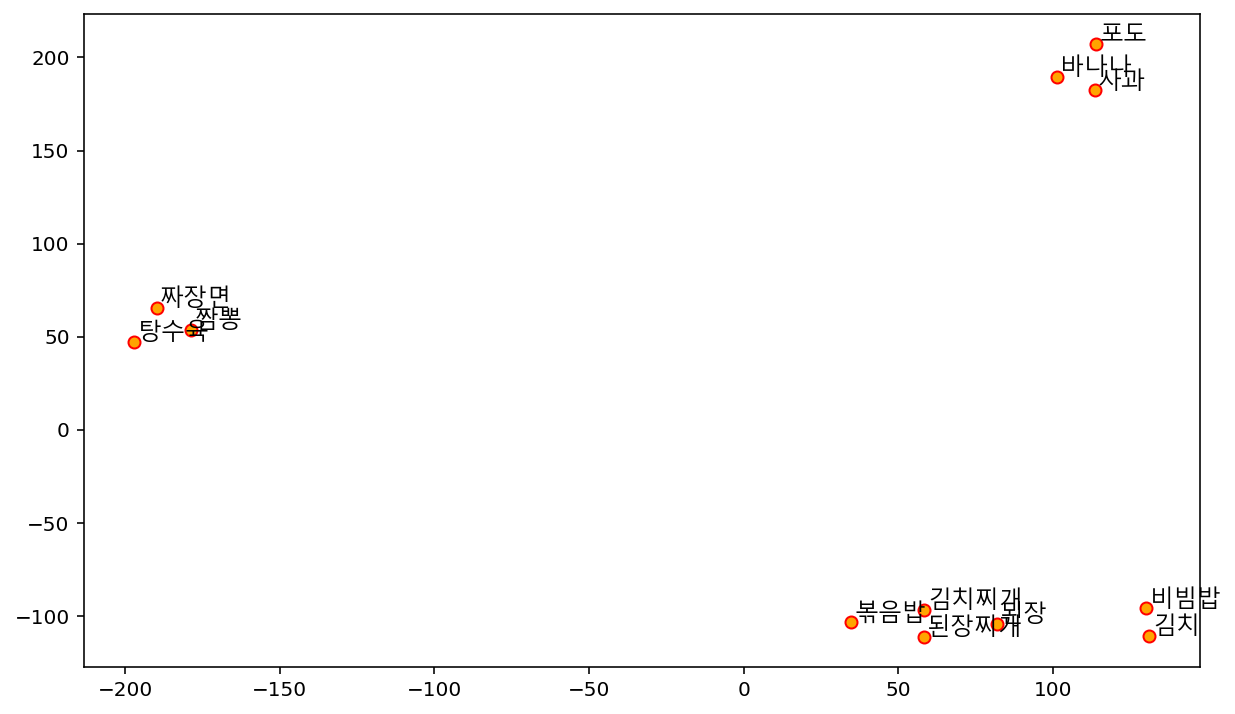

In [97]:
visualize_vectors(vectors, labels)